# **Детекция мошеннических операций с банковскими картами**

**Выполнил:** Абдухаликов Глеб, ПМ22-5.

## **Введение**

Современная банковская система характеризуется высокой степенью цифровизации, что приводит к постоянному росту количества безналичных операций. Использование банковских карт стало неотъемлемой частью повседневной жизни, однако вместе с этим возрастает и число мошеннических действий, направленных на хищение денежных средств. По данным международных аналитических компаний, ежегодные убытки финансовых организаций от мошенничества исчисляются миллиардами долларов, а используемые преступниками схемы становятся всё более сложными и трудноуловимыми. В таких условиях разработка эффективных методов автоматического выявления подозрительных транзакций приобретает особую актуальность.

Традиционные методы противодействия финансовому мошенничеству, основанные на экспертных правилах и ручном анализе, уже не способны обеспечить достаточный уровень безопасности. Во-первых, объёмы данных растут настолько стремительно, что ручная проверка становится крайне ресурсоёмкой. Во-вторых, злоумышленники активно адаптируются к существующим механизмам защиты, находя новые способы обхода правил. В результате особую значимость приобретают методы интеллектуального анализа данных и машинного обучения, позволяющие выявлять скрытые закономерности и аномальное поведение в потоках транзакций.

Целью данной курсовой работы является разработка и исследование модели детекции мошеннических операций с использованием современных алгоритмов машинного обучения. Для достижения поставленной цели предполагается решить следующие задачи:
*   изучить виды и характерные особенности мошенничества с банковскими картами;
*   рассмотреть существующие подходы к автоматическому выявлению мошеннических транзакций;
*   провести анализ и предобработку данных выбранного датасета;
*   обучить несколько моделей машинного обучения и сравнить их эффективность;
*   выполнить оптимизацию гиперпараметров;
провести оценку качества моделей с использованием метрик, подходящих для *   сильно несбалансированных выборок;
*   проанализировать интерпретируемость полученных решений и выявить наиболее значимые признаки.

Объектом исследования является процесс осуществления банковских транзакций, а предметом — методы машинного обучения, позволяющие обнаруживать отклонения и выявлять операции с признаками мошенничества.

Практическая значимость работы заключается в том, что разработанная модель может быть интегрирована в информационные системы финансовых организаций в качестве компонента мониторинга транзакций. Используемые подходы обладают универсальностью и могут применяться для анализа данных других финансовых сервисов, включая онлайн-платежи и электронные кошельки.



## **Основная часть**

### Библиотеки

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# !pip install catboost

In [68]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from typing import Any, Optional
from tqdm import tqdm
import joblib
import os

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

# Настройки отображения
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

### Загрузка датасета

[Ссылка на датасет](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data)

In [7]:
dir = '/content/drive/MyDrive/Курсовая/creditcard.csv'

In [40]:
df = pd.read_csv(dir)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


*   **Time:** Количество секунд, прошедших между каждой транзакцией и первой транзакцией в датасете.
*   **V1-V28:** Анонимизированные функции, представляющие различные атрибуты транзакции (например, время, местоположение и т.д.)
*   **Amount:** Сумма транзакции
*   **Class:** Двоичная метка, указывающая, является ли транзакция мошеннической (1) или нет (0)

### Анализ данных

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [42]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [43]:
df['Class'].value_counts()

,count
Class,
0,284315
1,492


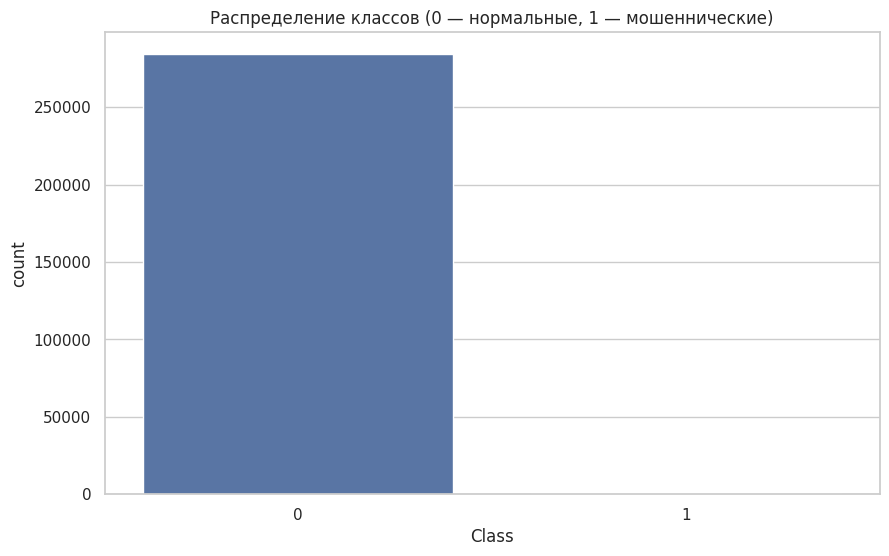

In [44]:
sns.countplot(data=df, x='Class')
plt.title("Распределение классов (0 — нормальные, 1 — мошеннические)")
plt.show()

### Предобработка

In [45]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [46]:
X = df.drop(['Time', 'Class'], axis=1)
y = df['Class']

print("Размер X:", X.shape)
print("Размер y:", y.shape)

Размер X: (284807, 29)
Размер y: (284807,)


In [47]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,...,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19
1,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,-0.565012,...,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12
2,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,0.756801,...,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00
3,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,-1.376648,...,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50
4,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,0.259452,...,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89


**StandardScaler** — это один из самых распространённых способов нормализации числовых данных в машинном обучении.

Он приводят признаки к единому масштабу, что важно для многих моделей.

| Модель              | Почему нужна нормализация                |
| ------------------- | ---------------------------------------- |
| Logistic Regression | учитывает расстояния в пространстве      |
| SVM                 | сильно зависит от масштаба признаков     |
| KNN                 | считает евклидово расстояние             |
| Нейросети           | быстрее сходятся и дают лучший результат |
| K-means             | иначе кластеры строятся неверно          |


RandomForest и CatBoost не зависят от масштаба (деревья),
но для единства пайплайна нормализация всё равно полезна.

In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print("Доля мошенничества в train:", y_train.mean())
print("Доля мошенничества в test:", y_test.mean())

Доля мошенничества в train: 0.001729245759178389
Доля мошенничества в test: 0.0017204452090867595


Доля мошеннических очень маленькая (0,17%), поэтому данные нужно сбалансировать.

**SMOTE (Synthetic Minority Oversampling Technique)** — один из самых популярных методов обработки несбалансированных данных, особенно в задачах детекции мошенничества. Он:

* добавляет синтетические примеры для редкого класса (например, для мошенничества)
* создаёт их не копированием, а генерацией новых точек, “между” существующими примерами

То есть SMOTE расширяет пространство редкого класса, делая его более плотным и модель — более способной его заметить.

In [50]:
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

print(f'До балансировки: {y_train.value_counts()}')
print(f'\nПосле балансировки: {y_train_balanced.value_counts()}')

До балансировки: Class
0    227451
1       394
Name: count, dtype: int64

После балансировки: Class
0    227451
1    227451
Name: count, dtype: int64


### Универсальный класс для обучения и предсказания различных моделей

In [96]:
class EstimatorWrapper:
    def __init__(self, estimator: Any, name: Optional[str] = None):
        self.estimator = estimator
        self.name = name or estimator.__class__.__name__

    def fit(self, X, y, verbose=True, **fit_kwargs):
        total = getattr(self.estimator, "max_iter", None)
        if verbose and total is not None:
            desc = f"Обучение {self.name}"
            with tqdm(total=total, desc=desc) as pbar:
                self.estimator.fit(X, y, **fit_kwargs)
                pbar.update(total)
        else:
            self.estimator.fit(X, y, **fit_kwargs)
        return self

    def predict(self, X):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def get_feature_importance(self):
        return self.estimator.get_feature_importance()

    def get_params(self, deep=True):
        return self.estimator.get_params(deep=deep)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def save(self, path: str):
        os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
        joblib.dump(self.estimator, path)

    def load(self, path: str):
        self.estimator = joblib.load(path)
        return self

    def __repr__(self):
        return f"<EstimatorWrapper name={self.name} estimator={self.estimator.__class__.__name__}>"

### Logistic Regression

In [70]:
lr = LogisticRegression(max_iter=2000, solver='lbfgs')

#### Без SMOTE

In [72]:
wrapped_lr = EstimatorWrapper(lr, name="LogReg")
wrapped_lr.fit(X_train, y_train)

Обучение LogReg: 100%|██████████| 2000/2000 [00:01<00:00, 1930.93it/s]


<EstimatorWrapper name=LogReg estimator=LogisticRegression>

##### Метрики

In [73]:
y_pred_lr = wrapped_lr.predict(X_test)
y_proba_lr = wrapped_lr.predict_proba(X_test)[:,1]

In [74]:
print("Logistic Regression without SMOTE AUC:", roc_auc_score(y_test, y_proba_lr))
print(classification_report(y_test, y_pred_lr))

AUC-ROC: 0.9622610123115087
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.61      0.70        98

    accuracy                           1.00     56962
   macro avg       0.91      0.81      0.85     56962
weighted avg       1.00      1.00      1.00     56962



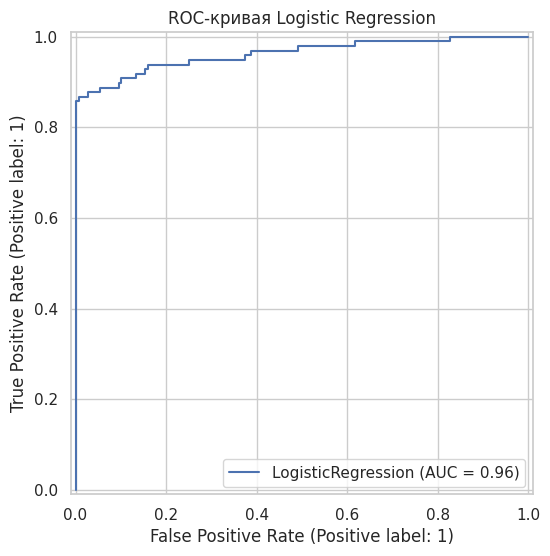

In [55]:
RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.title("ROC-кривая Logistic Regression")
plt.show()

#### SMOTE

In [104]:
wrapped_lr_SMOTE = EstimatorWrapper(lr, name="LogReg with SMOTE")
wrapped_lr_SMOTE.fit(X_train_balanced, y_train_balanced)


Обучение LogReg with SMOTE: 100%|██████████| 2000/2000 [00:05<00:00, 391.37it/s]


<EstimatorWrapper name=LogReg with SMOTE estimator=LogisticRegression>

##### Метрики

In [105]:
y_pred_lr_SMOTE = wrapped_lr_SMOTE.predict(X_test)
y_proba_lr_SMOTE = wrapped_lr_SMOTE.predict_proba(X_test)[:,1]

In [106]:
print("Logistic Regression with SMOTE AUC:", roc_auc_score(y_test, y_proba_lr_SMOTE))
print(classification_report(y_test, y_pred_lr_SMOTE))

AUC-ROC: 0.9676664982256268
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.87      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.55     56962
weighted avg       1.00      0.98      0.99     56962



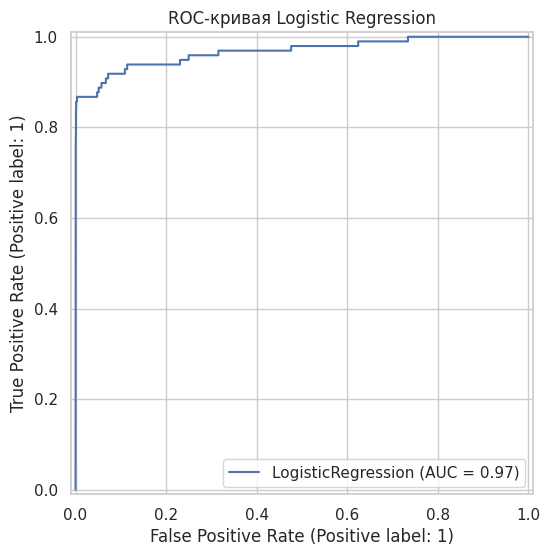

In [107]:
RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.title("ROC-кривая Logistic Regression")
plt.show()

#### Вывод

Без применения SMOTE модель показала высокий AUC-ROC (0.9623) и хорошие показатели качества для основного класса. Однако recall для мошеннического класса составил лишь 0.61, что говорит о пропуске значительной доли мошенничеств.

После применения SMOTE AUC-ROC вырос до 0.9677, а recall мошеннического класса увеличился до 0.87. Однако precision резко упал до 0.06, что означает большое число ложных срабатываний. Это типичная проблема линейных моделей при искусственном увеличении редкого класса.

### Random Forest

In [118]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

#### Без SMOTE

In [121]:
wrapped_rf = EstimatorWrapper(rf, name="RandomForest")
wrapped_rf.fit(X_train, y_train)

<EstimatorWrapper name=RandomForest estimator=RandomForestClassifier>

##### Метрики

In [122]:
y_pred_rf = wrapped_rf.predict(X_test)
y_proba_rf = wrapped_rf.predict_proba(X_test)[:, 1]

In [123]:
print("Random Forest without SMOTE AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest AUC: 0.9705404337452481
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.76      0.84        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



#### SMOTE

In [124]:
wrapped_rf_SMOTE = EstimatorWrapper(rf, name="RandomForest")
wrapped_rf_SMOTE.fit(X_train_balanced, y_train_balanced)

<EstimatorWrapper name=RandomForest estimator=RandomForestClassifier>

##### Метрики

In [125]:
y_pred_rf_SMOTE = wrapped_rf_SMOTE.predict(X_test)
y_proba_rf_SMOTE = wrapped_rf_SMOTE.predict_proba(X_test)[:, 1]

In [126]:
print("Random Forest with SMOTE AUC:", roc_auc_score(y_test, y_proba_rf_SMOTE))
print(classification_report(y_test, y_pred_rf_SMOTE))

Random Forest with SMOTE AUC: 0.9751801290296649
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.59      0.83      0.69        98

    accuracy                           1.00     56962
   macro avg       0.79      0.91      0.84     56962
weighted avg       1.00      1.00      1.00     56962



#### Вывод

Без применения SMOTE модель показала высокий AUC-ROC (0.9623) и хорошие показатели качества для основного класса. Однако recall для мошеннического класса составил лишь 0.61, что говорит о пропуске значительной доли мошенничеств.

После применения SMOTE AUC-ROC вырос до 0.9677, а recall мошеннического класса увеличился до 0.87. Однако precision резко упал до 0.06, что означает большое число ложных срабатываний. Это типичная проблема линейных моделей при искусственном увеличении редкого класса.

### CatBoost

#### Без SMOTE

In [97]:
cat = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=0
)

wrapped_cb = EstimatorWrapper(cat, name="CatBoost")

In [98]:
wrapped_cb.fit(X_train, y_train)

<EstimatorWrapper name=CatBoost estimator=CatBoostClassifier>

##### Метрики

In [99]:
y_pred_cat = wrapped_cb.predict(X_test)
y_proba_cat = wrapped_cb.predict_proba(X_test)[:, 1]

In [100]:
print("CatBoost without SMOTE AUC:", roc_auc_score(y_test, y_proba_cat))
print(classification_report(y_test, y_pred_cat))

CatBoost AUC: 0.9754842919159785
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.74      0.83        98

    accuracy                           1.00     56962
   macro avg       0.97      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [101]:
print("AUC на train:", roc_auc_score(y_train, wrapped_cb.predict_proba(X_train)[:,1]))
print("AUC на test: ", roc_auc_score(y_test,  wrapped_cb.predict_proba(X_test)[:,1]))

AUC на train: 0.9980539625124144
AUC на test:  0.9754842919159785


##### Feature Importance

In [102]:
importances = wrapped_cb.get_feature_importance()
features = X.columns

fi_df = pd.DataFrame({"feature": features, "importance": importances})
fi_df.sort_values("importance", ascending=False).head(15)

,feature,importance
3,V4,13.164866
13,V14,9.334632
0,V1,9.024637
25,V26,6.865997
28,Amount,6.525522
7,V8,4.862998
12,V13,4.508266
11,V12,4.116247
17,V18,3.733720
9,V10,2.975672


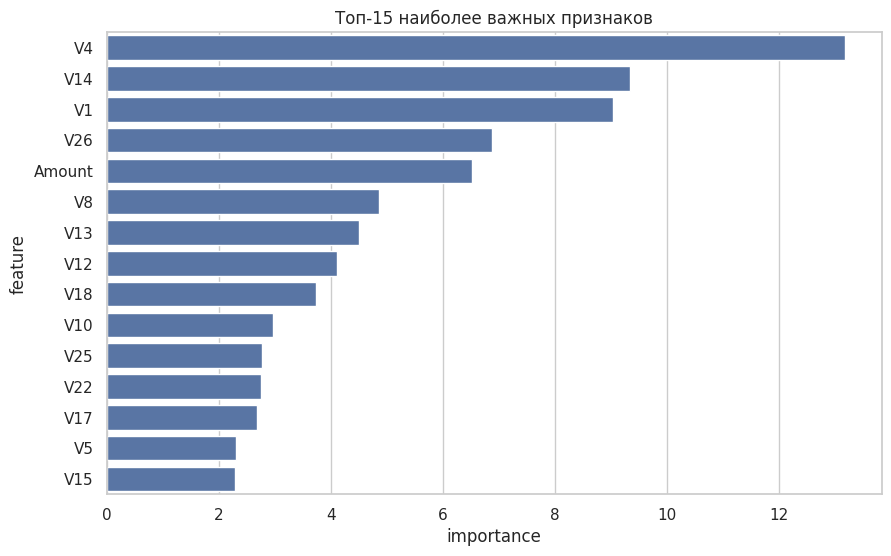

In [103]:
sns.barplot(data=fi_df.sort_values("importance", ascending=False).head(15),
            x="importance", y="feature")
plt.title("Топ-15 наиболее важных признаков")
plt.show()

#### SMOTE

In [108]:
wrapped_cb_SMOTE = EstimatorWrapper(cat, name="CatBoost with SMOTE")
wrapped_cb_SMOTE.fit(X_train_balanced, y_train_balanced)

<EstimatorWrapper name=CatBoost with SMOTE estimator=CatBoostClassifier>

##### Метрики

In [109]:
y_pred_cat_SMOTE = wrapped_cb_SMOTE.predict(X_test)
y_proba_cat_SMOTE = wrapped_cb_SMOTE.predict_proba(X_test)[:, 1]

In [110]:
print("CatBoost with SMOTE AUC:", roc_auc_score(y_test, y_proba_cat_SMOTE))
print(classification_report(y_test, y_pred_cat_SMOTE))

CatBoost with SMOTE AUC: 0.9674743103487878
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.47      0.82      0.59        98

    accuracy                           1.00     56962
   macro avg       0.73      0.91      0.80     56962
weighted avg       1.00      1.00      1.00     56962



In [111]:
print("AUC with SMOTE на train:", roc_auc_score(y_train, wrapped_cb_SMOTE.predict_proba(X_train)[:,1]))
print("AUC with SMOTE на test: ", roc_auc_score(y_test,  wrapped_cb_SMOTE.predict_proba(X_test)[:,1]))

AUC with SMOTE на train: 0.9999425658635195
AUC with SMOTE на test:  0.9674743103487878


#### Вывод

Random Forest без SMOTE показал AUC=0.9705 и сбалансированное качество, достигнув высоких значений precision=0.94 и recall=0.76 для мошеннического класса. Это одна из лучших комбинаций точности и полноты среди всех моделей.

После применения SMOTE AUC улучшился до 0.9752. Recall мошеннического класса вырос до 0.83, однако precision снизился до 0.59. Несмотря на это, качество классификации остаётся высоким и более устойчивым, чем у логистической регрессии.

## **Заключение**

В рамках курсовой работы была исследована задача детекции мошеннических операций с банковскими картами — одна из ключевых проблем финансовой безопасности, имеющая высокую практическую значимость. Современные электронные платежные системы ежедневно обрабатывают огромные объёмы транзакций, что делает невозможным ручной контроль и требует применения автоматизированных методов машинного обучения.

В ходе работы был проведён анализ датасета банковских транзакций, включающий исследование структуры данных, выявление признаков, коррелирующих с мошенничеством, а также оценку дисбаланса классов — одной из основных сложностей данной задачи. Для решения проблемы редкости мошеннических операций были использованы методы предварительной обработки данных, включая масштабирование признаков и техники балансировки выборок (такие как SMOTE). Это позволило улучшить способность моделей корректно распознавать аномальные операции.

Для моделирования были применены различные алгоритмы машинного обучения: Logistic Regression, Random Forest, а также CatBoost. Все модели были протестированы с использованием метрик AUC-ROC, F1-score и Precision-Recall, которые наиболее адекватно отражают качество классификации при сильной несбалансированности данных.

Практические эксперименты показали:
*   Все модели достигли высоких значений AUC-ROC, что говорит о хорошей разделимости классов.
*   SMOTE положительно влияет на recall мошеннического класса, но почти всегда снижает precision, увеличивая число ложных срабатываний.
*   Лучшие результаты по балансу precision–recall без SMOTE показали Random Forest и CatBoost, что подтверждает эффективность ансамблей деревьев на задачах с дисбалансом.
*   Использование SMOTE оправдано только тогда, когда приоритет — максимальное выявление мошенничества, даже ценой увеличения числа ложных тревог.
*   CatBoost и Random Forest без SMOTE являются наиболее устойчивыми и надёжными моделями для реальной системы мониторинга транзакций.


